In [1]:
# IMPORTING LIBRARIES
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt
import random

In [2]:
np.random.seed(0) # setting seed for random number generation, so that results are consistent in multiple runs of the code

In [3]:
# VARIABLE DECLARATION

# Share specific information
S0 = 100
r = 0.08
sigma = 0.3

# Call option specific information
K = 100
T = 1
k_log = np.log(K)

# Model specific information
v0 = 0.06
kappa = 9
theta = 0.06
rho = -0.4

# Approximation information
t_max = 30 # effective upper bound of integration
N = 100 # number of terms in summations used to approximate integrals


Fourier Call Price = 13.734895692109077
Analytical Call Price = 15.711312547892973


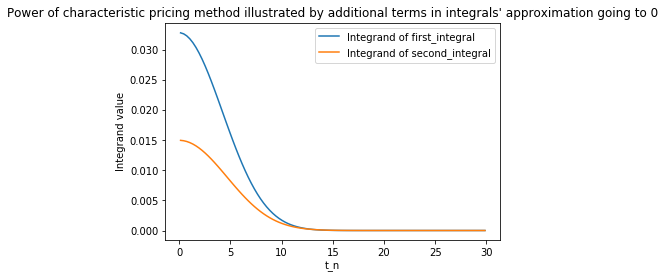

In [4]:
"TASK 1: USING A SIMPLE FOURIER PRICING TECHNIQUE, PRICE A VANILLA CALL OPTION"
"ASSUMING THAT THE UNDERLYING SHARE FOLLOWS THE HESTON MODEL DYNAMICS"
#Functions used for calcualting characterstics function to implement Heston Model
#𝜙𝑠t = exp(𝐶(𝜏;𝑢)+𝐷(𝜏;𝑢)*𝑣𝑡+𝑖*𝑢*𝑙𝑜𝑔(𝑆𝑡)) where 𝐶(𝜏;𝑢)=𝑟*𝑖*𝜏*𝑢+𝜃*𝜅[𝜏*𝑥 − (1/𝑎)* 𝑙𝑜𝑔( (1−𝑔*𝑒xp(𝑑𝜏))/(1−𝑔))]
#𝐷(𝜏;𝑢)= ((1−𝑒xp(𝑑𝜏))/(1−𝑔*𝑒xp(𝑑𝜏)))*𝑥− , 𝑔 =𝑥−/𝑥+, 𝑥±=(𝑏±𝑑)/2𝑎, 𝑑 = sqrt(𝑏2−4𝑎𝑐), 𝑐 =−(𝑢**2+𝑢*𝑖)/2, 𝑏=𝜅−𝜌*𝜎*𝑖*𝑢, 𝑎=σ**2/2

a = sigma**2/2

def b(u):
    return kappa - rho*sigma*1j*u

def c(u):
    return -(u**2+1j*u)/2

def d(u):
    return np.sqrt(b(u)**2-4*a*c(u))

def xminus(u):
    return (b(u)-d(u))/(2*a)

def xplus(u):
    return(b(u)+d(u))/(2*a)

def g(u):
    return xminus(u)/xplus(u)

#𝐶(𝜏;𝑢)
def C(u):
    val1 = T*xminus(u)-np.log((1-g(u)*np.exp(-T*d(u)))/(1-g(u)))/a
    return r*T*1j*u + theta*kappa*val1

#𝐷(𝜏;𝑢)
def D(u):
    val1 = 1-np.exp(-T*d(u))
    val2 = 1-g(u)*np.exp(-T*d(u))
    return (val1/val2)*xminus(u)

#characteristic function (𝜙𝑠t) as stated in eq 34 of Module 5
def log_char(u):
    return np.exp(C(u) + D(u)*v0 + 1j*u*np.log(S0))

#For Heston model we will be using characteristic function proposed by Albrecher et al. (2007)
#𝜙𝑠t =𝜙𝑠t(𝑢−𝑖) / 𝜙𝑠t(−𝑖)
def adj_char(u):
    return log_char(u-1j)/log_char(-1j)

def analytical_callprice(S0, K, r, sigma, T):
    #We calculate analytical price of vanilla Erueopean call option - for comparison with estimates
    # We use the Black-Scholes closed-form solution given by:
    # Price of option C = S0*Phi(d1) - K*e^(-r*(T-current_time))*Phi(d2)
    # where d1 = (ln(S0/strike)+(risk_free+sigma^2/2)*(T-current_time))/(sigma*sqrt(T-current_time))
    # d2 = d1-sigma*sqrt(T-current_time),
    # S0 = initial stock price, K = strike price, r = continuously compounded risk-free interest rate,
    # sigma = stock price volatility, T = time to option maturity, current_time = time of option-price calculation is assumed as 0
    d_1_stock = (np.log(S0/K)+(r+np.power(sigma,2)/2)*T)/(np.array(sigma)*np.sqrt(T))
    d_2_stock = d_1_stock - np.array(sigma)*np.sqrt(T)
    return S0*norm.cdf(d_1_stock) - K*np.exp(-r*T)*norm.cdf(d_2_stock)

analytical_callprice_task1 = analytical_callprice(S0, K, r, sigma, T)

#Variables  for approximating the value of the integral
delta_t = t_max/N
from_1_to_N = np.linspace(1,N,N)
t_n = (from_1_to_N - 1/2)*delta_t

#first_integral equates to first integral in Fourier Call price equation
first_integral = sum((((np.exp(-1j*t_n*k_log)*adj_char(t_n)).imag)/t_n)*delta_t)

#second_integral equates to second integral in Fourier Call price equation
second_integral = sum((((np.exp(-1j*t_n*k_log)*log_char(t_n)).imag)/t_n)*delta_t)

#combining first and second integrals estimate to get  call price through complete Fourier call price equation 
#𝑐=𝑆0*ℚ𝑆[𝑆t>𝐾]−𝑒*(−𝑟𝑇)*𝐾*ℚ[𝑆t>𝐾], S0 = initial stock price, K = strike price, r = continuously compounded risk-free interest rate
fourier_call_val = S0*(1/2 + first_integral/np.pi) - np.exp(-r*T)*K*(1/2 + second_integral/np.pi)

#Output of Analytical call price (closed solution) and Fourier Call price using Heston model
print("Fourier Call Price = ", end="")
print(fourier_call_val)
print("Analytical Call Price = ", end="")
print(analytical_callprice_task1)

# Plotting integrands - to show how quickly the additional terms in integral approximation go to 0
# Illustrates power of the characteristic pricing method
plt.plot(t_n,(((np.exp(-1j*t_n*k_log)*adj_char(t_n)).imag)/t_n)*delta_t)
plt.plot(t_n,(((np.exp(-1j*t_n*k_log)*log_char(t_n)).imag)/t_n)*delta_t)
plt.xlabel("t_n")
plt.ylabel("Integrand value")
plt.legend(['Integrand of first_integral','Integrand of second_integral'])
plt.title("Power of characteristic pricing method illustrated by additional terms in integrals' approximation going to 0")
plt.show()

In [5]:
"TASK 2: SIMULATE PATHS FOR THE UNDERLYING SHARE USING SAMPLE SIZES OF 1000, 2000, ..., 50000"
"DO MONTHLY SIMULATIONS FOR A PERIOD OF A YEAR"
"S(t_i+1) = S(t_i)*exp((r - sigma^2(t_i,t_i+1)/2)(t_i+1-t_i)+Z*sigma(t_i,t_i+1)*sqrt(t_i+1-t_i))"
"where S(t_i) is the share price at time t_i, r is the risk-free interest rate and Z~N(0,1), "
"and sigma(t_i,t_i+1) is volatility for the period [t_i,t_i+1] given by sigma*(S(t_i)^(gamma-1)) by CEV model"

gamma = 0.75 # parameter to estimate local volatility using CEV model
dT = 1/12 # increments of time at which prices on the path are to be calculated - monthly simulations over 1 year

# Function to generate volatility by CEV model
def CEV_local_volatility(S_ti):
    # It takes input S_ti = share price at time t_i
    # And generates local volatility for the period [t_i,t_i+1] given by:
    # sigma(t_i,t_i+1) = sigma*(S(t_i)^(gamma-1)) (according to CEV model)
    return sigma*S_ti**(gamma-1)

# Function to generate path of share prices
def share_path(S_0, R, Z):
    # It takes following inputs:
    # S_0 = initial share price, R = risk-free rate, Z = series of standard normal random variables, 
    # dT = time-increments at which values are to be calculated, T = whole time horizon of path
    # And generates the share price path at dT intervals over T time
    
    n = len(Z) # number of increments
    S_prev = S_0 # share price at previous time-increment: starts with S_0
    localvols = [None]*n # pre-allocating space for the array of local volatilities
    price_path = [None]*n # pre-allocating space for share price path
    
    for i in range(1,int(n+1)): # looping over time-increments
       # calculating local volatility using function defined above
        localvols[i-1] = CEV_local_volatility(S_prev)
        # calculating and storing next price using formula explained at the top of this section
        price_path[i-1] = S_prev*np.exp((R - localvols[i-1]**2/2)*dT + localvols[i-1]*np.sqrt(dT)*Z[i-1])
        # updating previous share price to latest calculated price - will be used in next iteration of for-loop
        S_prev = price_path[i-1]
    
    return price_path, localvols # returning the price-path and array of local volatilities

#Function for discounted payoff/price  of a vanilla European call option
def call_payoff_disc(S_term, K, R, T):
    # It takes following inputs:
    # S_term = terminal share price at end of price path, because European option can be exercised only at option maturity
    # K = strike, R = risk-free rate, T = maturity of option
    # And returns payoff of the vanilla European call option
    return np.exp(-R*T)*np.maximum((S_term-K),0)
    
# Using different sample sizes - 1000, 2000, ..., 50000 to simulate share price paths:

# Pre-allocating space for monthly share prices, local volatilities, and option payoffs
share_prices = [np.empty([i*1000,12]) for i in range(1,51)] # "empty" list of 50 numpy matrices - one for each sample size
local_volatilities = [np.empty([i*1000,12]) for i in range(1,51)] # "empty" list of 50 numpy matrices - one for each sample size
option_payoffs = [[None]*i*1000 for i in range(1,51)] # list of None lists - one for each sample size

# Calculating share price path and option payoff for each sample
for i in range(1,51): # looping over samples of different sizes - 1000 to 50000
    for j in range(i*1000): # iterating <sample-size> number of times
        # generating monthly random values for stock over 1 year from a standard normal distribution
        norm_matrix = norm.rvs(size = np.array([1,int(T/dT)]))
        # generating share prices and local volatilities (1st and 2nd variables returns from function defined above)
        # and storing in the appropriate pre-allocated space
        share_prices[i-1][j],local_volatilities[i-1][j] = share_path(S0, r, norm_matrix[0,])
        # calculating option payoff for each price path
        option_payoffs[i-1][j] = call_payoff_disc(share_prices[i-1][j][-1],K,r,T) # share_prices[i-1][j][-1] = terminal share price

In [6]:
"TASK 3: CALCULATE MONTE CARLO ESTIMATES AND STANDARD DEVIATIONS OF THESE ESTIMATES FOR PRICE OF THE VANILLA EUROPEAN CALL OPTION"
"P.S. Part of this task (option payoff calculation) has already been completed in the above section.."
".. so that we don't have to run the same loops (i from 1 to 50, and j from 0 to i*1000) twice"

# Calculating means and std devs of option payoffs for the different samples    
option_price_estimates = [np.mean(option_payoffs[i-1]) for i in range(1,51)] # mean values of option's payoff from samples 
option_price_stdevs = [np.std(option_payoffs[i-1])/np.sqrt(i*1000) for i in range(1,51)] # standard deviation of option's payoff from samples 


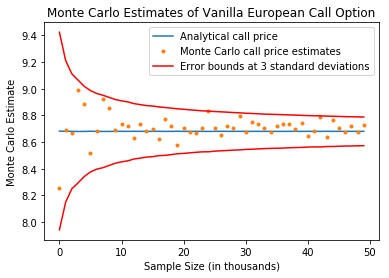

In [7]:
"TASK 4: PLOT MONTE CARLO ESTIMATES ALONG WITH ERROR BOUNDS AT 3 STANDARD DEVIATIONS WITH INCREASING SAMPLE-SIZE"

# First, we calculate the analytical call prices for comparison
# But, the Black-Scholes (BS) closed-form solution for analytical option price assumes fixed volatility
# And the model we have used takes local volatilities
# So, we have used the average local volatility from each sample as the fixed volatility when applying the BS solution
avg_volatility = [np.mean(local_volatilities[i-1]) for i in range(1,51)] # mean values of local volatilities from samples 
analytical_callprices = analytical_callprice(S0, K, r, avg_volatility, T)

# Plotting estimates against analytical option price for increasing sample size
plt.plot(analytical_callprices) # plotting analytical prices as a line
plt.plot(option_price_estimates,'.') # plotting estimates as points
# plotting upper and lower error bound at 3 std. devs. from analytical put price as red lines
plt.plot(analytical_callprices + np.array(option_price_stdevs)*3, 'r') 
plt.plot(analytical_callprices - np.array(option_price_stdevs)*3, 'r')
# setting x and y labels, and title for the plot
plt.xlabel("Sample Size (in thousands)")
plt.ylabel("Monte Carlo Estimate")
plt.legend(['Analytical call price','Monte Carlo call price estimates','Error bounds at 3 standard deviations'])
plt.title("Monte Carlo Estimates of Vanilla European Call Option")
plt.show() # displaying the plot